In [123]:
import os

import numpy as np
import networkx as nx
import pandas as pd

import matplotlib as mpl
from matplotlib import pyplot as plt

datapath = "../data"
localdatapath = "../local_data"

mpl.rcParams["font.family"] = "serif"
mpl.rcParams["figure.dpi"]  = 300

Load book dataset (requires that you have the books locally in `chapters.csv`)

In [124]:
df = pd.read_csv(os.path.join(localdatapath, "book.csv"), header=0, index_col=0)
df["names"] = df.apply(lambda r: eval(r["names"]), axis=1)
df.head(10)

,book,title,text,names
0,0,PROLOGUE,"PROLOGUE\n\n\n\n“We should start back,” Gared ...","[Jon Snow, Robert Baratheon]"
1,0,BRAN,BRAN\n\n\n\n\n\nThe morning had dawned clear a...,"[Jon Snow, Eddard 'Ned' Stark, Robert Baratheo..."
2,0,CATELYN,CATELYN\n\n\n\n\n\nCatelyn had never liked thi...,"[Eddard 'Ned' Stark, Jon Snow, Robert Baratheo..."
3,0,DAENERYS,DAENERYS\n\n\n\n\n\nHer brother held the gown ...,"[Jorah Mormont, Viserys Targaryen, Daenerys Ta..."
4,0,EDDARD,EDDARD\n\n\n\n\n\nThe visitors poured through ...,"[Robert Baratheon, Eddard 'Ned' Stark, Jon Sno..."
5,0,JON,"JON\n\n\n\n\n\nThere were times—not many, but ...","[Jon Snow, Robert Baratheon, Eddard 'Ned' Star..."
6,0,CATELYN,CATELYN\n\n\n\n\n\nOf all the rooms in Winterf...,"[Eddard 'Ned' Stark, Robert Baratheon, Jon Sno..."
7,0,ARYA,ARYA\n\n\n\n\n\nArya’s stitches were crooked a...,"[Jon Snow, Sansa Stark, Robb Stark, Joffrey Ba..."
8,0,BRAN,BRAN\n\n\n\n\n\nThe hunt left at dawn. The kin...,"[Jon Snow, Robert Baratheon, Eddard 'Ned' Star..."
9,0,TYRION,TYRION\n\n\n\n\n\nSomewhere in the great stone...,"[Eddard 'Ned' Stark, Robert Baratheon, Benjen ..."


Summary statistics about book chapters

In [125]:
print(f"""
Number of chapters: {len(df)}
Number of words:    {sum(len(c.split()) for c in df.text)}
Number of letters:  {sum(len(c) for c in df.text)}
""")


Number of chapters: 358
Number of words:    1741449
Number of letters:  9419747



Load redditor data (requires you have it locally)

In [126]:
df_reddit = pd.read_csv(os.path.join(localdatapath, "asoiaf_data_cleaned.csv"), header=0, index_col=0)
df_reddit["names"] = df_reddit.apply(lambda r: eval(r["names"]), axis=1)
df_reddit.head(10)

,title,score,created,author,selftext,names
3,(Spoilers extended) This sub is going to explo...,7,1555189915,seperationsunday,2019. r/asoiaf is about to E.X.P.L.O.D.E\r\n\r...,[]
7,[SPOILERS EXTENDED] Miiri’s Prophecy,2,1555187335,ChayaFeige,Miiri Maaz Dur Prophecy decoded using Gilly’s ...,[]
8,(Spoilers Main) GOT Theory: You Can't Trust th...,47,1555186553,John-on-gliding,The events that led to the creation of the Whi...,[Brandon 'Bran' Stark]
10,(Spoilers extended)The Night King needs Bran,3,1555184407,dikziw,Ever since the episode where Bran is “marked” ...,"[Jon Snow, Brandon 'Bran' Stark]"
16,(Spoilers Extended) Ending theory: a Tudor Wes...,101,1555182090,5555512369874,ASOIAF has a number of historical inspirations...,"[Petyr 'Littlefinger' Baelish, Jon Snow, Varys]"
17,(Spoilers main) To Fan the Fires of Hype,0,1555181818,SoulofSummer,"I follow JT Music, and while his content is hi...",[]
18,To Fan the Fires of Hype,1,1555181013,SoulofSummer,"I follow JT Music, and while his content is hi...",[]
20,(Spoilers Extended) ADWD Epilogue - In defense...,32,1555179728,WootGorilla,The Epilogue of *A Dance with Dragons* is told...,"[Eddard 'Ned' Stark, Cersei Lannister, Daenery..."
21,(Spoilers Extended) Nothing There to Be Overex...,0,1555179570,TheWayItIz,I find myself not excited for Season 8 at all!...,[Sandor Clegane]
23,(Spoilers Main) GOT entire series recap recomm...,2,1555176618,hoke24,"I finished my re-watch of the show, but are th...",[]


In [127]:
print(f"""
Number of posts:    {len(df_reddit)}
Number of words:    {sum(len(c.split()) for c in df_reddit.selftext)}
Number of letters:  {sum(len(c) for c in df_reddit.selftext)}
""")


Number of posts:    72090
Number of words:    15297004
Number of letters:  88291619



Load both graphs built by `graphing.py`

In [128]:
G_book = nx.read_gpickle(os.path.join(datapath, "book.nxgraph"))
G_reddit = nx.read_gpickle(os.path.join(datapath, "asoiaf_data_cleaned.nxgraph"))

In [129]:
print(
f"""
Book character graph:
Nodes: {len(G_book.nodes())}
Edges: {len(G_book.edges())}
Avg. degree: {np.mean(list(d for _, d in G_book.degree()))}
""" 
)



Book character graph:
Nodes: 34
Edges: 483
Avg. degree: 28.41176470588235



In [130]:
print(
f"""
Reddit character graph:
Nodes:       {len(G_reddit.nodes())}
Edges:       {len(G_reddit.edges())}
Avg. degree: {np.mean(list(d for _, d in G_reddit.degree()))}
""" 
)


Reddit character graph:
Nodes:       34
Edges:       561
Avg. degree: 33.0



In [131]:
def plot_graph(G: nx.Graph, weight_cutoff: int = 0.1, max_node_size: int = 400, pos=None):
    H = G.copy() # H is tG, just mutated for plotting

    H.remove_edges_from([e for e, w in nx.get_edge_attributes(H,'weight').items() if w < weight_cutoff] )
    edge_sizes = list(nx.get_edge_attributes(H,'weight').values())

    max_deg = max(d for _, d in H.degree()) 
    node_sizes = list((d/max_deg)**3 * max_node_size for _, d in H.degree()) # Scale polynomially node size with number of connections
    
    pos = nx.drawing.layout.kamada_kawai_layout(H) if pos is None else pos
    fig, ax = plt.subplots(figsize=(16, 9))

    nx.draw_networkx_nodes(H, pos=pos, ax=ax, node_size=node_sizes, node_color="r")
    nx.draw_networkx_edges(H, pos=pos, ax=ax, edge_color=edge_sizes, edge_cmap=plt.cm.Oranges)
    nx.draw_networkx_labels(H, pos=pos, ax=ax, font_family="serif", font_size=10, horizontalalignment="center", verticalalignment="top")

    plt.show()
    return pos

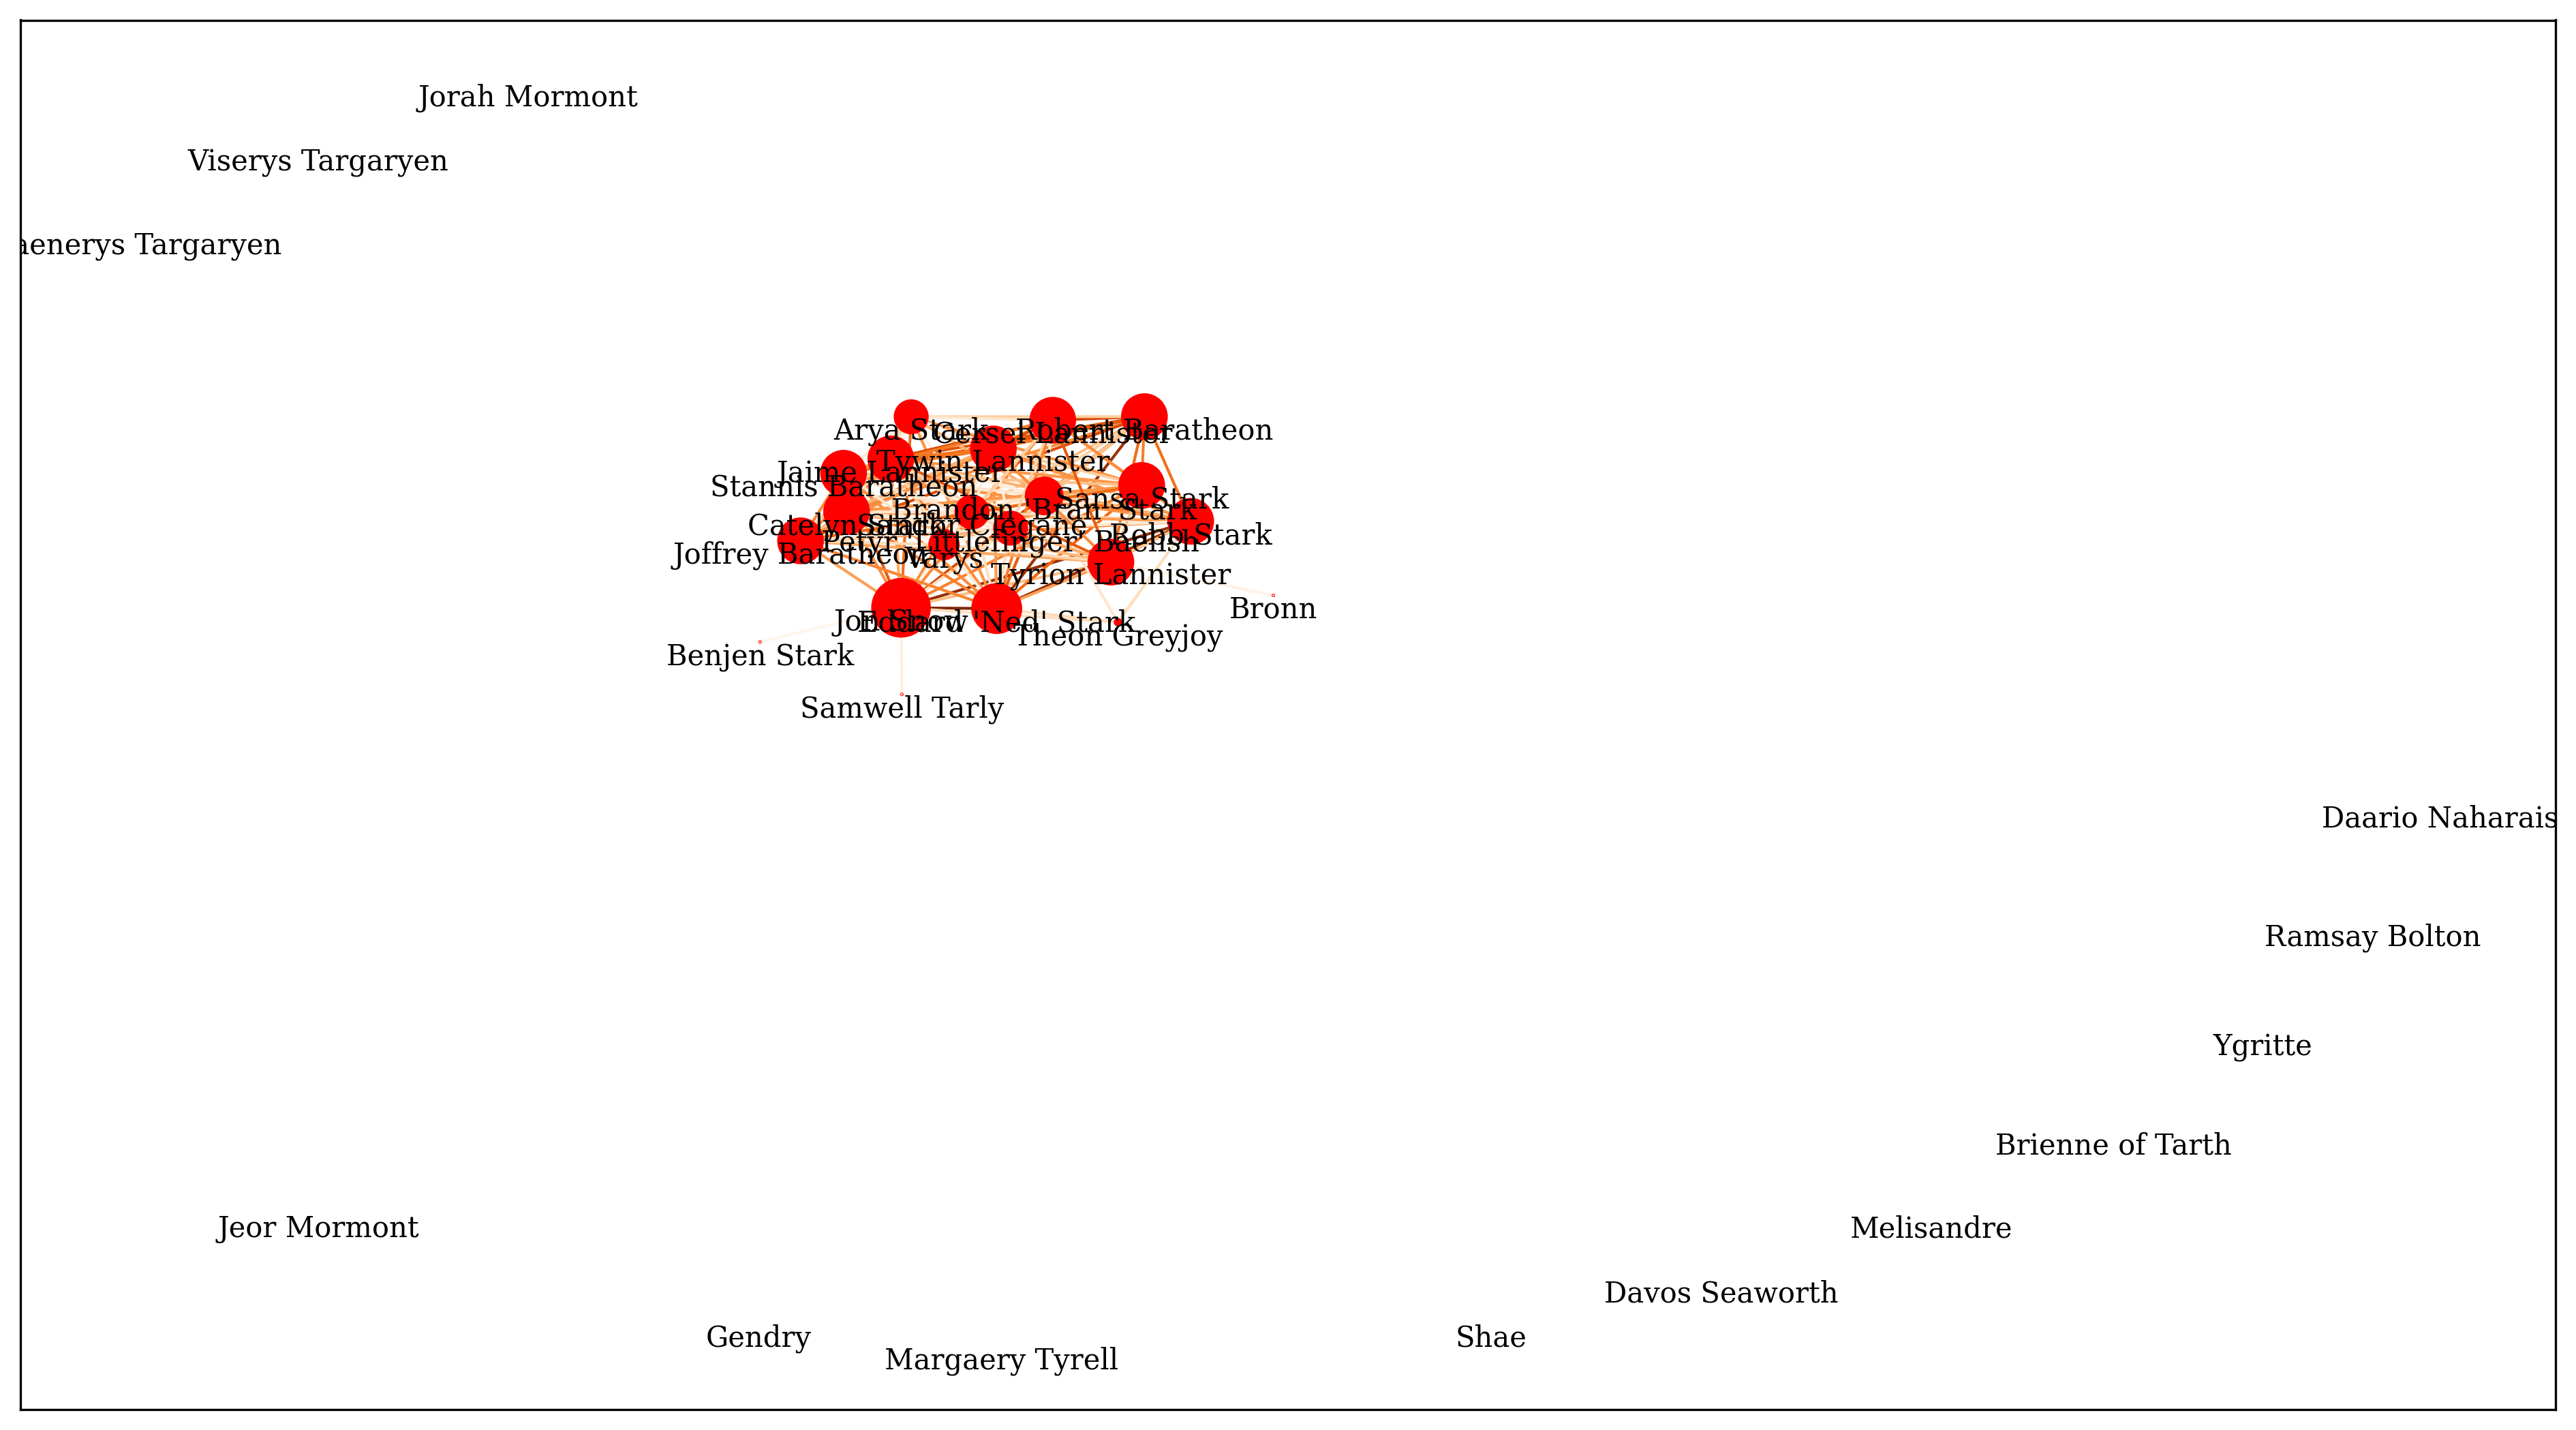

In [159]:
"""
INITIAL BOOK GRAPH
"""

pos = plot_graph(G_book, weight_cutoff=0.1)

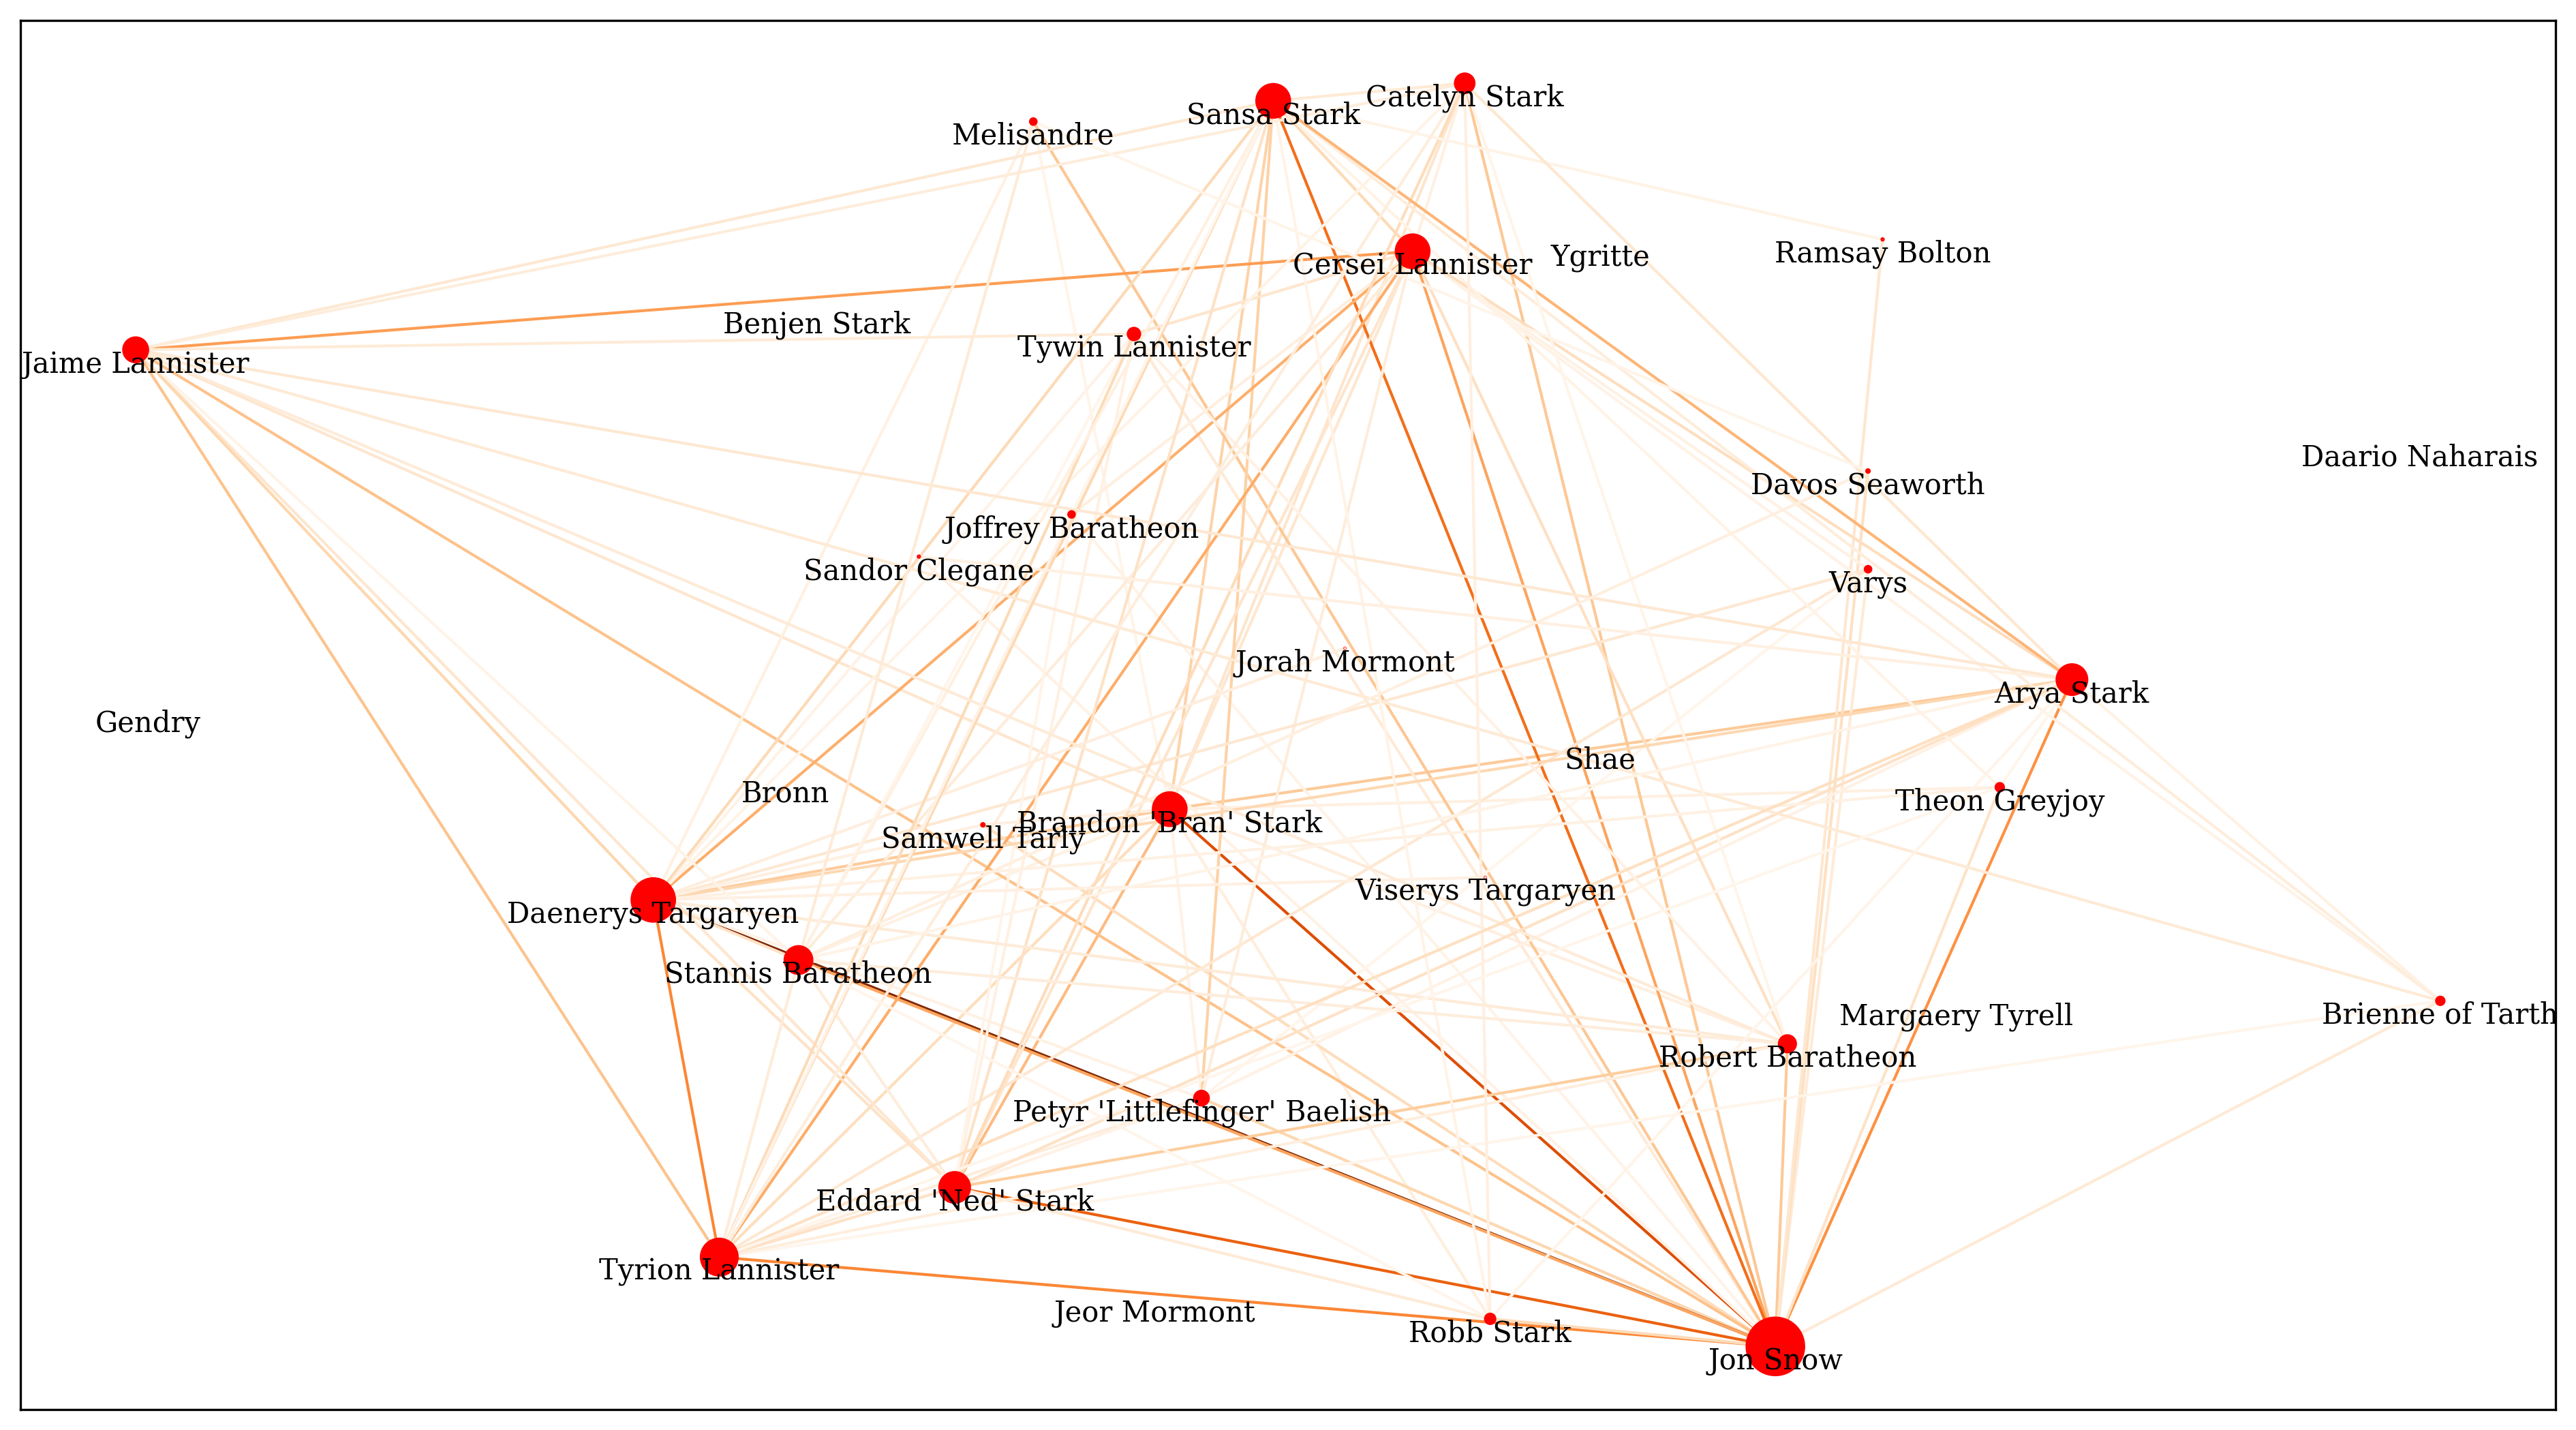

In [134]:
"""
INITIAL REDDIT GRAPH
"""
_ = plot_graph(G_reddit, weight_cutoff=0.01, pos=pos)

Weight distribution for Books. Mean: 7.49, std.: 7.87
Weight distribution for Reddit. Mean: 0.67, std.: 0.79


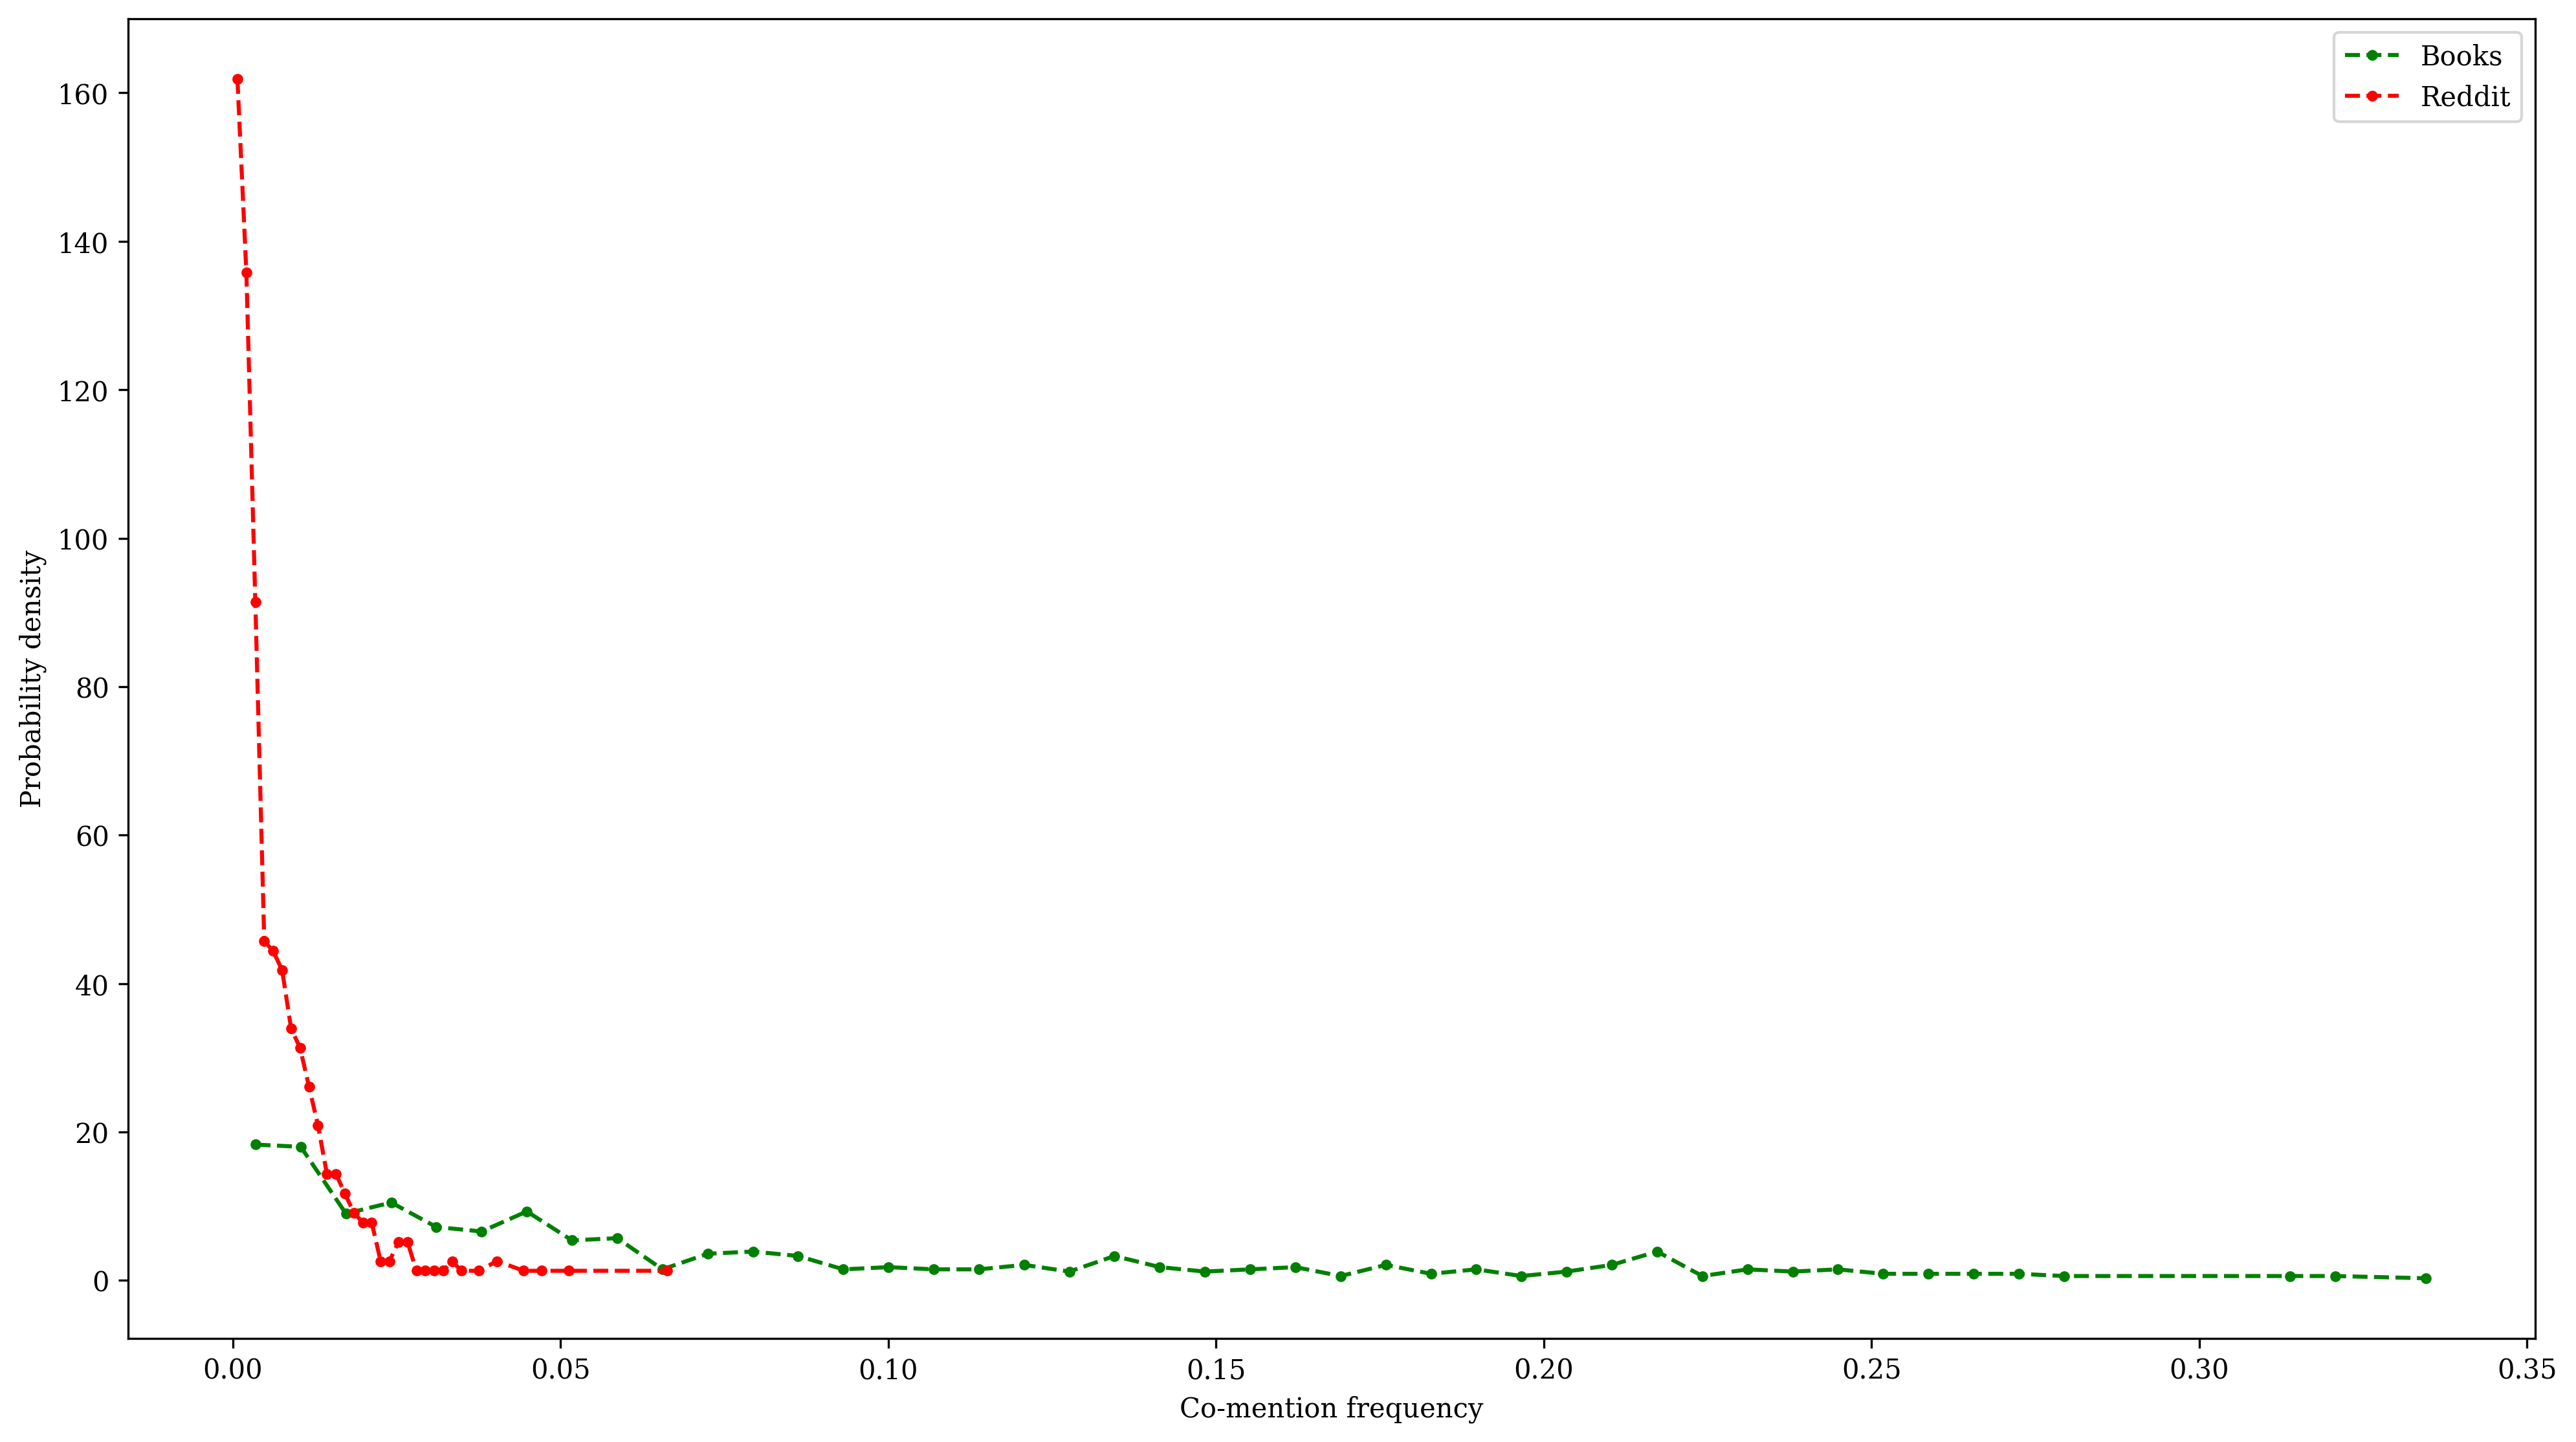

In [141]:
""" Weight distribution """
fig, ax = plt.subplots(figsize = (16, 9))

names = ("Books", "Reddit")
colours = "gr"

n_bins = 50

for i, G in enumerate((G_book, G_reddit)):
    weights = np.array(list(nx.get_edge_attributes(G,'weight').values()))
    bins = np.linspace(0, weights.max(), n_bins)

    hist, edges = np.histogram(weights, bins=bins, density=True)

    x = (edges[1:] + edges[:-1])/2

    ax.plot(x[hist > 0], hist[hist > 0], marker='.', color=colours[i], ls="--", label=names[i])
    
    print(f"Weight distribution for {names[i]}. Mean: {weights.mean()*100:.2f}, std.: {weights.std()*100:.2f}")


ax.legend()
ax.set_xlabel("Co-mention frequency")
ax.set_ylabel("Probability density")

plt.show()

In [148]:
""" Shortest paths """
d_book = nx.average_shortest_path_length(G_book, weight="weight")
d_red = nx.average_shortest_path_length(G_reddit, weight="weight")
print(f"Book: {d_book:.4f}, Reddit: {d_red:.4f}")

Book: 0.0122, Reddit: 0.0011


In [152]:
c_book = nx.algorithms.average_clustering(G_book, weight="weight")
c_red = nx.algorithms.average_clustering(G_reddit, weight="weight")
print(f"Book: {c_book:.4f}, Reddit: {c_red:.4f}")

Book: 0.1600, Reddit: 0.0811
